# COMP0173: Coursework 2

The paper HEARTS: A Holistic Framework for Explainable, Sustainable, and Robust Text Stereotype Detection by Theo King, Zekun Wu et al. (2024) presents a comprehensive approach to analysing and detecting stereotypes in text [1]. The authors introduce the HEARTS framework, which integrates model explainability, carbon-efficient training, and accurate evaluation across multiple bias-sensitive datasets. By using transformer-based models such as ALBERT-V2, BERT, and DistilBERT, this research project demonstrates that stereotype detection performance varies significantly across dataset sources, underlining the need for diverse evaluation benchmarks. The paper provides publicly available datasets and code [2], allowing full reproducibility and offering a standardised methodology for future research on bias and stereotype detection in Natural Language Processing (NLP).

# Instructions

All figures produced during this notebook are stored in the project’s `/COMP0173_Figures` directory.
The corresponding LaTeX-formatted performance comparison tables, including ALBERT-V2, BERT, and DistilBERT are stored in `/COMP0173_PDF`, with the compiled document available as `COMP0173-CW2-TABLES.pdf`.

# Technical Implementation (70%)

In [19]:
# %%capture
# pip install -r requirements.txt
# pip install transformers
# pip install --upgrade transformers
# pip install --upgrade tokenizers
# pip install -U sentence-transformers
# pip install natasha
# pip install datasets
# pip install --user -U nltk
# conda install -c anaconda nltk
# pip install --upgrade openai pandas tqdm
# pip install dotenv
# python -m spacy download ru_core_news_lg

In [20]:
# pip install -U pip setuptools wheel
# pip install -U spacy
# python -m spacy download en_core_web_trf
# python -m spacy download en_core_web_sm
# python -m spacy download ru_core_news_lg

# # GPU
# pip install -U 'spacy[cuda12x]'
# # GPU - Train Models
# pip install -U 'spacy[cuda12x,transformers,lookups]'

In [21]:
# Import the libraries 
import random, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(color_codes=True)
plt.style.use('seaborn-v0_8')

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')
np.random.seed(23)

warnings.filterwarnings(
    "ignore",
    message="pkg_resources is deprecated as an API"
)

In [22]:
# Import libraries 
import pandas as pd
import os
import sys
import importlib.util, pathlib
from pathlib import Path
import warnings 
from importlib import reload
from importlib.machinery import SourceFileLoader
from IPython.display import display
import pandas as pd
from pathlib import Path
import re
import difflib
import string
from collections import defaultdict
import json
import gc

In [23]:

import torch
import transformers
from transformers import AutoModelForMaskedLM, XLMWithLMHeadModel
from transformers import AutoTokenizer, AutoConfig
from transformers import TrainingArguments, Trainer
from sentence_transformers import SentenceTransformer, util
import platform
from datasets import Dataset
# import spacy 
import requests
from tqdm import tqdm
import yaml
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [24]:
sys.path.append("Exploratory Data Analysis")
sys.path.append("Model Training and Evaluation")

from Initial_EDA import (
    prepare_target_variable_distribution,
    prepare_group_distribution,
    prepare_text_length_analysis,
    create_word_cloud
)

from Sentiment_Toxicity_Analysis_Ru import analyse_sentiment_and_regard

In [25]:
# # Check the GPU host (UCL access)
# print("CUDA available:", torch.cuda.is_available())
# print("Device:", torch.cuda.get_device_name(0))

# # Path
# import os
# os.chdir("/tmp/HEARTS-Text-Stereotype-Detection")
# os.getcwd()

## Part 5: Evaluate the adapted model, comparing performance metrics with the original study

### Helper Functions

In [26]:
def extract_macro_f1(path):
    df = pd.read_csv(path)
    row = df[df.iloc[:, 0].str.contains("macro", case=False, na=False)]
    return float(row["f1-score"].values[0])

In [42]:
def build_table(dataset_name):
    rows = []
    for model_name, folder in MODEL_FOLDERS.items():
        report_path = os.path.join(folder, dataset_name, "classification_report.csv")
        if os.path.exists(report_path):
            macro = extract_macro_f1(report_path)
            rows.append([model_name, macro])

    df = pd.DataFrame(rows, columns=["Model", "Macro F1"])
    df = df.sort_values("Macro F1", ascending=False).reset_index(drop=True)

    return df

In [51]:
def plot_table(df, title):
    
    """
    Single-series barplot styled similarly to `_grouped_barplot`:
    - seaborn whitegrid
    - soft y-grid only
    - no black bar outlines
    - clean title & ticks
    """

    sns.set_style("whitegrid")

    models = df["Model"].tolist()
    scores = df["Macro F1"].values

    x = np.arange(len(models))

    fig, ax = plt.subplots(figsize=(6, 3), dpi=200)

    # Bars (no outlines, seaborn-like colour)
    palette = sns.color_palette("Purples_d", len(models))
    ax.bar(
        x,
        scores,
        color=palette,
        edgecolor=None,      
    )

    # X ticks
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=0, fontsize=7)

    # Y axis from 0 to 1 (Macro F1)
    ax.set_ylim(0, 1.0)
    ax.set_yticks(np.linspace(0, 1.0, 6))
    ax.tick_params(axis="y", labelsize=9)
    ax.set_ylabel("")

    # Title in same style
    ax.set_title(title, fontsize=14, fontweight="bold", pad=12, y = 1.1)

    # Grid only on y
    ax.grid(axis="y", color="0.75", linewidth=0.5)
    ax.grid(axis="x", visible=False)

    # Remove extra spines like in your grouped plot
    sns.despine(ax=ax)

    # Optional: small text labels above bars (can comment out if you hate them)
    for xi, val in zip(x, scores):
        ax.text(
            xi,
            val + 0.015,
            f"{val:.3f}",
            ha="center",
            va="bottom",
            fontsize=8,
        )

    fig.tight_layout()
    plt.show()

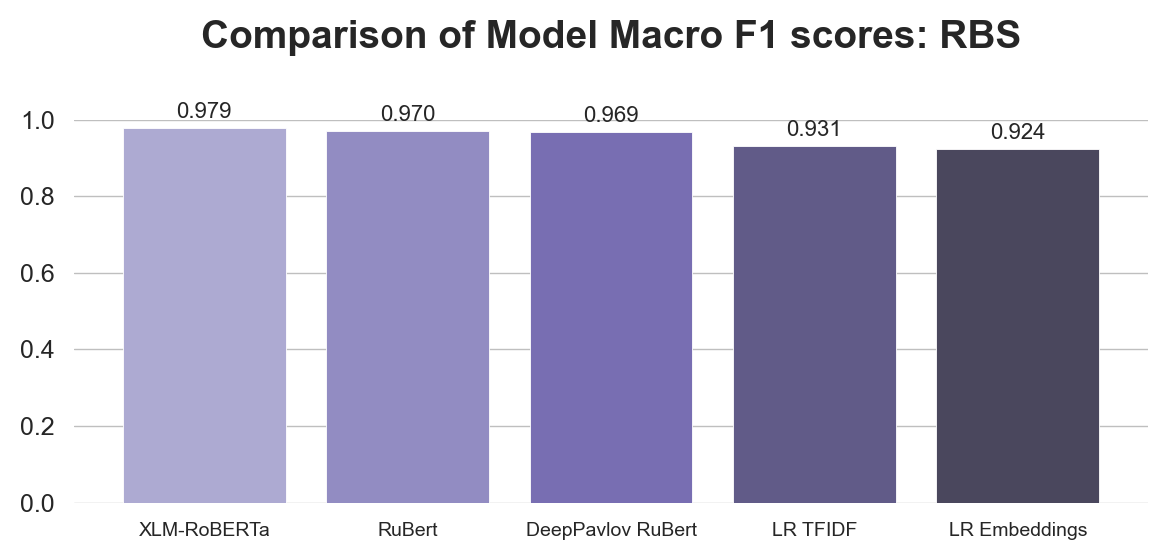

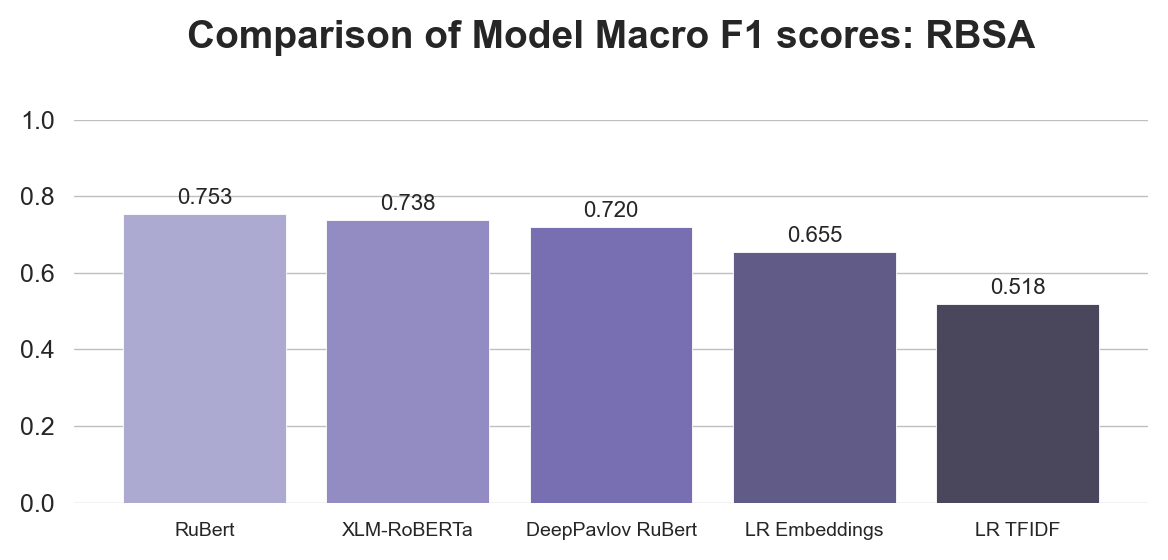

In [58]:
MODEL_FOLDERS = {
    "LR TFIDF": "result_output_LR_tfidf",
    "LR Embeddings": "result_output_LR_embedding",
    "DeepPavlov RuBert": "result_output_deeppavlov_rubert",    
    "RuBert": "result_output_ruberta_base",
    "XLM-RoBERTa": "result_output_xlm_roberta_base",
}

DATASETS = ["rubist_trained", "rubist_second_trained"]

table_A = build_table("rubist_trained")
table_B = build_table("rubist_second_trained")

plot_table(table_A, "Comparison of Model Macro F1 scores: RBS")
plot_table(table_B, "Comparison of Model Macro F1 scores: RBSA")

In [62]:
table_A = build_table("rubist_trained").copy()
table_B = build_table("rubist_second_trained").copy()

table_A["Macro F1"] = (table_A["Macro F1"] * 100).map("{:.1f}%".format)
table_B["Macro F1"] = (table_B["Macro F1"] * 100).map("{:.1f}%".format)

print(table_A)
print(table_B)

               Model Macro F1
0        XLM-RoBERTa    97.9%
1             RuBert    97.0%
2  DeepPavlov RuBert    96.9%
3           LR TFIDF    93.1%
4      LR Embeddings    92.4%
               Model Macro F1
0             RuBert    75.3%
1        XLM-RoBERTa    73.8%
2  DeepPavlov RuBert    72.0%
3      LR Embeddings    65.5%
4           LR TFIDF    51.8%


### $\color{pink}{Question\ 1:}$ Compare original vs. adapted model performance

### $\color{pink}{Question\ 2:}$ Use appropriate metrics for problem type

### $\color{pink}{Question\ 3:}$ Conduct statistical significance testing

### $\color{pink}{Question\ 4:}$ Analyze failure cases

## References 

[1] Theo King, Zekun Wu, Adriano Koshiyama, Emre Kazim, and Philip Treleaven. 2024.
HEARTS: A holistic framework for explainable, sustainable and robust text stereotype detection.
arXiv preprint arXiv:2409.11579.
Available at: https://arxiv.org/abs/2409.11579
(Accessed: 4 December 2025).
https://doi.org/10.48550/arXiv.2409.11579

[2] Theo King, Zekun Wu, Adriano Koshiyama, Emre Kazim, and Philip Treleaven. 2024.
HEARTS-Text-Stereotype-Detection (GitHub Repository).
Available at: https://github.com/holistic-ai/HEARTS-Text-Stereotype-Detection
(Accessed: 4 December 2025).

[3] Theo King, Zekun Wu, Adriano Koshiyama, Emre Kazim, and Philip Treleaven. Holistic AI. 2024.
EMGSD: Expanded Multi-Group Stereotype Dataset (HuggingFace Dataset).
Available at: https://huggingface.co/datasets/holistic-ai/EMGSD
(Accessed: 4 December 2025).

[4] University College London Technical Support Group (TSG).
2025. GPU Access and Usage Documentation.
Available at: https://tsg.cs.ucl.ac.uk/gpus/
(Accessed: 6 December 2025).

[5] United Nations. 2025. The 2030 Agenda for Sustainable Development. 
Available at: https://sdgs.un.org/2030agenda 
(Accessed: 6 December 2025).

[] Natasha. Russian NLP Library (conda-forge distribution). Available at:
https://anaconda.org/conda-forge/natasha
(Accessed 8 December 2025).

[] Anthropic. Claude Artifact. Available at:
https://claude.ai/public/artifacts/ab5532d8-7d61-4a98-acec-5cc4236f0d74
(Accessed: 8 December 2025).

## References: Data Collection

Gender Stereotypes

https://adme.media/articles/11-stereotipov-o-muzhchinah-i-zhenschinah-kotorye-davno-ustareli-no-mnogie-s-nimi-tak-i-zhivut-2526726/

https://t-j.ru/gender-stereotypes-cases/?utm_referrer=https%3A%2F%2Fwww.google.com%2F

https://klinikaexpert.ru/articles/v-yarlykah-lozhnye-stereotipy-o-muzhchinah-i-zhenschinah

https://news.zerkalo.io/life/54154.html

https://www.sbras.info/articles/editors/gendernye-stereotipy-v-kotorye-pora-perestat-verit

https://www.rbc.ua/ukr/styler/rozpovsyudzheni-ta-zastarili-stereotipi-cholovikiv-1709482914.html

https://burninghut.ru/stereotipy-o-muzhchinakh-i-zhenshhinakh/

https://www.sravni.ru/text/5-stereotipov-o-muzhchinakh-i-zhenshhinakh-kotorye-plokho-vlijajut-na-finansy-semi/

Profession Stereotypes

https://psy.1sept.ru/article.php?ID=200301712

https://peopletalk.ru/article/10-samyh-populyarnyh-stereotipov-o-professiyah-kotorye-besyat/

https://adukar.com/by/news/abiturientu/stereotipy-o-professiyah

https://kemgmu.ru/about_the_university/news/11672/

https://dzen.ru/a/YZ81OX7HcALiVr1k

https://nafi.ru/en/analytics/samye-rasprostranennye-stereotipy-rossiyan-ob-it-professiyakh-/

https://mosdigitals.ru/blog/pochemu-ne-lyubyat-yuristov-osnovnye-prichiny-i-stereotipy

https://medium.com/juris-prudence/%D1%82%D1%80%D0%B0%D0%B4%D0%B8%D1%86%D0%B8%D0%B8-%D1%8E%D1%80%D0%B8%D1%81%D1%82%D0%BE%D0%B2-%D0%BF%D1%80%D0%B0%D0%B2%D0%B4%D0%B0-%D0%B2%D1%8B%D0%BC%D1%8B%D1%81%D0%B5%D0%BB-%D0%B1%D1%83%D0%BB%D1%88%D0%B8%D1%82-cc3de98cdfec

https://stereotypes_actors.tilda.ws/

https://m.vk.com/wall-181816199_1644

https://kovrov.ecvdo.ru/states/stereotipy-o-professii-ekonomista-chto-pravda-a-chto-vymysel

https://urzhum.ecvdo.ru/states/razvenchivaem-mify-o-professii-finansista

https://azov.ecvdo.ru/states/mify-o-populyarnyh-professiyah?utm_referrer=https%3A%2F%2Fwww.google.com%2F

https://igrim.ecvdo.ru/states/mify-i-pravda-o-rabote-v-sfere-obrazovaniya?utm_referrer=https%3A%2F%2Fwww.google.com%2F

https://brodude.ru/8-stereotipov-o-rabote-shef-povara/

https://www.maximonline.ru/lifestyle/7-glavnykh-mifov-o-rabote-bortprovodnikov-id6443401/

https://www.sports.ru/football/blogs/477244.html

https://dnmu.edu.ua/old/pro-meditsinu/3633-o-hirurgah

https://vc.ru/id3158218/1127046-mify-o-pilotah-ty-tozhe-tak-dumal

https://www.psychologies.ru/wellbeing/5-strashnyih-mifov-o-detskom-balete-v-kotoryie-pora-perestat-verit/

https://masterok.livejournal.com/11781279.html

https://adme.media/articles/10-mifov-o-balete-kotorye-kinoshniki-pridumali-radi-vau-effekta-a-my-i-kupilis-2514646/

https://mir24.tv/articles/16379683/8-glavnyh-stereotipov-o-rabote-advokata-merkantilnye-ciniki-ili-professionaly

https://omsk.ecvdo.ru/states/mify-o-dizajnerskoj-professii-razbiraemsya-chto-pravda-a-chto-net?utm_referrer=https%3A%2F%2Fwww.google.com%2F

https://media.contented.ru/vdohnovenie/kofebrejk/5-mifov-o-dizaynerah/

https://ashleyhome.am/ru/blogs/news/steriotipy-o-dizainerax

https://lifehacker.ru/7-stereotipov-o-rabote-barmena/

https://klepachsv.livejournal.com/24127.html

https://www.championat.com/lifestyle/article-4793635-razoblachaem-top-9-stereotipov-o-sportsmenah-pravda-ili-vymysel.html

https://krasotuli.com/25199-stereotipy-o-parikmaherskom-dele-razvenchivaem-mify.html

https://maycenter.ru/blog/mifi-o-professii-parikmakhera

https://m.ok.ru/group/70000000389722/topic/157405964165210?opncmnt
https://nacasting.ru/statii/mify-o-rezhisserakh

https://omsk.ecvdo.ru/states/mify-o-professii-arhitektora-chto-na-samom-dele-vazhno-dlya-uspeha-v-etoj-sfere

http://www.lookatme.ru/flow/posts/fashion-radar/181029-mify-i-realii-o-modelnom-biznese

https://rylskova.com/%D0%BC%D0%B8%D1%84%D1%8B-%D0%BE-%D0%BF%D1%80%D0%BE%D1%84%D0%B5%D1%81%D1%81%D0%B8%D0%BE%D0%BD%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D1%85-%D1%84%D0%BE%D1%82%D0%BE%D0%B3%D1%80%D0%B0%D1%84%D0%B0%D1%85/

Nationality/Race Stereotypes

https://kuban24.tv/item/10-samyh-rasprostranennyh-stereotipov-o-raznyh-natsionalnostyah

https://mir24.tv/articles/16626782/10-stereotipov-ob-indejcah:-razoblachenie-mifov-i-udivitelnye-fakty

https://tandem.net/ru/blog/russian-stereotypes-fact-fiction

https://tandem.net/ru/blog/british-stereotypes-fact-or-myth

https://meschool.ru/poleznoe/top-7-stereotipov-o-britancakh/

https://linguacats.com/ru/stati/o-chjom-molchat-frantsuzhenki

https://smapse.livejournal.com/699411.html

https://francaisclub.ru/%D1%81%D1%82%D0%B5%D1%80%D0%B5%D0%BE%D1%82%D0%B8%D0%BF%D1%8B-%D0%BE-%D1%84%D1%80%D0%B0%D0%BD%D1%86%D1%83%D0%B7%D0%B0%D1%85/

https://www.bestprivateguides.com/articles/stereotipi-ob-italyantsah-art-69.php

https://maminklub.lv/rebionok/stereotipy-ob-ispantsakh-pravda-i-lozh-623074/

https://pikabu.ru/story/stereotipyi_ob_ispantsakh__pravda_i_vyimyisel_6306872

https://chetyre-jelania.livejournal.com/197804.html

https://www.staypoland.com/ru/poland/stereotipy-o-polshe/

https://abea.com.ua/ru/top-10-pravdyvykh-stereotypov-ob-ukrayne-y-ukrayntsakh

https://vancouverok.com/15-stereotipov-o-kanadtsah-kotorye-yavlyayutsya-pravdoj/

https://nashvancouver.com/6-lozhnih-stereotipov-o-kanadcax/

https://amivisa.ru/blog/usa/stereotipy-ob-amerikancax-pravda-i-vymysel/

https://www.english-language.ru/articles/informative/stereotipyi-ob-amerikanczax/

https://tonkosti.ru/%D0%96%D1%83%D1%80%D0%BD%D0%B0%D0%BB/11_%D0%B4%D0%B8%D0%BA%D0%BE%D0%B2%D0%B0%D1%82%D1%8B%D1%85_%D1%81%D1%82%D0%B5%D1%80%D0%B5%D0%BE%D1%82%D0%B8%D0%BF%D0%BE%D0%B2_%D0%BE_%D1%80%D1%83%D1%81%D1%81%D0%BA%D0%B8%D1%85,_%D0%B2_%D0%BA%D0%BE%D1%82%D0%BE%D1%80%D1%8B%D0%B5_%D0%B2%D0%B5%D1%80%D1%8F%D1%82_%D0%B0%D0%BC%D0%B5%D1%80%D0%B8%D0%BA%D0%B0%D0%BD%D1%86%D1%8B

https://dzen.ru/a/ZfHtqQPJj3LVcVWV

https://www.reddit.com/r/AskCentralAsia/comments/ahes8h/what_are_the_stereotypes_of_the_different_central/?tl=ru

https://am.tsargrad.tv/articles/5-stereotipov-pro-armjan-i-armeniju_395939

https://adme.media/articles/ya-zhivu-v-irane-i-hochu-rasskazat-o-10-veschah-kotorye-otkroyut-etu-stranu-s-drugoj-storony-1859715/

https://chilltravel.ru/iindiastereotipi

https://www.chaochay.ru/blog/9-mifov-o-kitae-i-kitajcah

https://smapse.ru/7-banalnyh-stereotipov-o-zhitelyah-yuzhnoj-korei/

https://lifehacker.ru/stereotipy-o-severnoi-koree/

https://moya-planeta.ru/reports/view/yaponcy_lomka_stereotipov_35074

https://smapse.ru/15-stereotipov-o-yaponcah-kotorye-oni-nenavidyat/



LGBTQ+ Stereotypes

https://denis-balin.livejournal.com/329915.html

https://sojka.io/ru/guides/lgbt

http://raznoobrasije.org/wp-content/uploads/2020/07/2020_Raznoobrasije_1_Mythen-und-Fakten-u%CC%88ber-LGB.pdf

https://spherequeer.org/bisexual-week-2023/

https://gpress.info/2020/03/13/stereotipy-o-lgbt-1/

https://parniplus.com/lgbt-movement/myths-about-bisexuality/


https://www.kok.team/ru/2018-04-26/stereotipy-o-lesbiyankah

https://yvision.kz/post/gei-i-lesbiyanki-mify-i-fakty-seksualnaya-patologiya-ili-estestvennyy-process-298823

https://whatisgood.ru/theory/analytics/ulovki-lgbt-propagand/

https://holod.media/2023/05/15/myths-about-trans-people/

https://vk.com/@ovsyanart-trans-people

https://rostovgazeta.ru/news/2017-02-17/samye-rasprostranennye-mify-o-transgenderah-1353439?utm_source=google.com&utm_medium=organic&utm_campaign=google.com&utm_referrer=google.com

## References  - Stereotype

[24] Kaustubh Shivshankar Shejole and Pushpak Bhattacharyya. 2025.  
StereoDetect: Detecting Stereotypes and Anti-stereotypes the Correct Way  
Using Social Psychological Underpinnings. arXiv preprint arXiv:2504.03352.  
Available at: https://arxiv.org/abs/2504.03352  
(Accessed: 6 December 2025).

## References: RuHateBe

[6] Anna Palatkina, Elisey Rykov, Elina Sigdel, and Anna Sukhanova. 2024. 
RUHABE: Russian Hate Speech Benchmark. 
Available at: https://disk.360.yandex.ru/i/Divcpu7LaJwchw  
(Accessed: 6 December 2025).

[7] Anna Palatkina, Elisey Rykov, Elina Sigdel, and Anna Sukhanova. 2024. 
RUHABE Dataset. 
Available at: https://disk.360.yandex.ru/d/hi3PF0XuoyCRlg  
(Accessed: 6 December 2025).

[8] Anna Palatkina, Elisey Rykov, Elina Sigdel, and Anna Sukhanova. 2024. 
RUHABE Website (GitHub Repository). 
Available at: https://github.com/Annasuhstuff/RUHABE-website 
(Accessed: 6 December 2025).

## References: Russian Distorted Toxicity

[12] Alla Goryacheva. 2023. Toxicity Detection in Russian: Thesis Project Repository.  
GitHub Repository. Available at: https://github.com/alla-g/toxicity-detection-thesis/  
(Accessed: 6 December 2025).

[13] Alla Goryacheva. 2023. Russian Distorted Toxicity Corpus (TSV file).  
In *Toxicity Detection in Russian: Thesis Project Repository*.  
Available at: https://github.com/alla-g/toxicity-detection-thesis/blob/main/toxicity_corpus/russian_distorted_toxicity.tsv  
(Accessed: 6 December 2025).

## References: Kaggle - Russian Language Toxic Comments

[14] Blackmoon. 2019. Russian Language Toxic Comments Dataset.  
Kaggle. Available at: https://www.kaggle.com/datasets/blackmoon/russian-language-toxic-comments  
(Accessed: 6 December 2025).

[15] Sergey Smetanin. 2020. Toxic Comments Detection in Russian.  
In *Computational Linguistics and Intellectual Technologies: Proceedings of the International Conference “Dialogue 2020”*.  
Available at: https://doi.org/10.28995/2075-7182-2020-19-1149-1159  
(Accessed: 6 December 2025).

## References: Kaggle - Russian Hate Speech Recognition

[23] Kamil Saitov and Leon Derczynski. 2021.  
Abusive Language Recognition in Russian.  
In *Proceedings of the 8th Workshop on Balto-Slavic Natural Language Processing*,  
Kiyv, Ukraine, 20–25. Association for Computational Linguistics.  
Available at: https://aclanthology.org/2021.bsnlp-1.3/  
(Accessed: 7 December 2025).

[20] Kamil Saitov and Leon Derczynski. 2021.   
Russian Hate Speech Recognition (GitHub Repository).  
Available at: https://github.com/Sariellee/Russan-Hate-speech-Recognition 
(Accessed: 6 December 2025).

## References: Kaggle - Misc

[16] Bertie Vidgen and Leon Derczynski. 2020.  
Directions in abusive language training data, a systematic review: Garbage in, garbage out.  
*PLOS ONE*, 15, 12, e0243300.  
Available at: https://doi.org/10.1371/journal.pone.0243300  
(Accessed: 6 December 2025).

[17] Fabio Poletto, Valerio Basile, Manuela Sanguinetti, Cristina Bosco, and Viviana Patti. 2021.  
Resources and benchmark corpora for hate speech detection: A systematic review.  
*Language Resources & Evaluation*, 55, 477–523.  
Available at: https://doi.org/10.1007/s10579-020-09502-8  
(Accessed: 6 December 2025).

[18] Surendrabikram Thapa, Aditya Shah, Farhan Jafri, Usman Naseem, and Imran Razzak. 2022.  
A Multi-Modal Dataset for Hate Speech Detection on Social Media: Case-study of Russia–Ukraine Conflict.  
In *Proceedings of the 5th Workshop on Challenges and Applications of Automated Extraction of Socio-political Events from Text (CASE)*,  
1–6. Abu Dhabi, United Arab Emirates (Hybrid). Association for Computational Linguistics.  
Available at: https://aclanthology.org/2022.case-1.1  
(Accessed: 6 December 2025).

[19] Surendrabikram Thapa, Farhan Ahmad Jafri, Kritesh Rauniyar, Mehwish Nasim, and Usman Naseem. 2024.  
RUHate-MM: Identification of Hate Speech and Targets using Multimodal Data from Russia–Ukraine Crisis.  
In *Companion Proceedings of the ACM Web Conference 2024 (WWW '24)*.  
Association for Computing Machinery, New York, NY, USA, 1854–1863.  
Available at: https://doi.org/10.1145/3589335.3651973  
(Accessed: 6 December 2025).

[21] Ekaterina Pronoza, Polina Panicheva, Olessia Koltsova, and Paolo Rosso. 2021.  
Detecting ethnicity-targeted hate speech in Russian social media texts.  
Information Processing & Management, 58, 6 (2021), 102674.  
Available at: https://www.sciencedirect.com/science/article/pii/S0306457321001606  
(Accessed: 6 December 2025).  
https://doi.org/10.1016/j.ipm.2021.102674

[22] X. Wen, Y. Wang, K. Wang, and R. Sui. 2022.  
A Russian Hate Speech Corpus for Cybersecurity Applications.  
In *Proceedings of the 2022 IEEE 8th International Conference on Big Data Security on Cloud (BigDataSecurity),  
IEEE International Conference on High Performance and Smart Computing (HPSC) and  
IEEE International Conference on Intelligent Data and Security (IDS)*, Jinan, China, 41–47.  
Available at: https://doi.org/10.1109/BigDataSecurityHPSCIDS54978.2022.00018  
(Accessed: 6 December 2025).